## Hypothesis

Predicting the exact score is hard. We could reduce the complexity by interpreting this challenge as an **ordinal classification** problem. The key point here is that the probability of `class_1` is lower than `class_0`. Multi-class or multi-label problems do not have this critical ingridient.

To start, we could reduce the number of classes from 100 to 10, and encode them in a way that let the model understand that the the probability of Pawpularity been higher than 20, is strictly lower than higher than 10.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ml.vision.data import ImageDataModule
from ml.learner import ImageClassifier
from ml.params import load_cfg

In [3]:
import pandas as pd

df = pd.read_csv("../data/train_folds.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold,ignore
0,0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0,0
1,1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2,0
2,2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,3,0
3,3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3,1
4,4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,1,0


One way to encode the ordinal information is:

* `class_0`: `[0, 0, 0, 0, 0, 0, 0, 0, 0]`,
* `class_1`: `[1, 0, 0, 0, 0, 0, 0, 0, 0]`,
* `class_2`: `[1, 1, 0, 0, 0, 0, 0, 0, 0]`,
* ...

Due to this encoding scheme, the model will learn that having the first 8 elements equal to 1 is less likely than having just the first 2 elements equal to 1.

At prediction/inference time, we can then postprocess the predictions to match the range of the original target variable ― e.g., `class_0` -> `5`, `class_9` -> `95`.

In [4]:
cls2enc = {
    0: [0, 0, 0, 0, 0, 0, 0, 0, 0],
    1: [1, 0, 0, 0, 0, 0, 0, 0, 0],
    2: [1, 1, 0, 0, 0, 0, 0, 0, 0],
    3: [1, 1, 1, 0, 0, 0, 0, 0, 0],
    4: [1, 1, 1, 1, 0, 0, 0, 0, 0],
    5: [1, 1, 1, 1, 1, 0, 0, 0, 0],
    6: [1, 1, 1, 1, 1, 1, 0, 0, 0],
    7: [1, 1, 1, 1, 1, 1, 1, 0, 0],
    8: [1, 1, 1, 1, 1, 1, 1, 1, 0],
    9: [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

# NOTE: lists are not hashable objects, so cannot be used as keys in
# a dictionary. One trick is to convert the list to a set, as these 
# are immutable and hashable
enc2cls = {tuple(v): k for k, v in cls2enc.items()}

In [5]:
enc2cls

{(0, 0, 0, 0, 0, 0, 0, 0, 0): 0,
 (1, 0, 0, 0, 0, 0, 0, 0, 0): 1,
 (1, 1, 0, 0, 0, 0, 0, 0, 0): 2,
 (1, 1, 1, 0, 0, 0, 0, 0, 0): 3,
 (1, 1, 1, 1, 0, 0, 0, 0, 0): 4,
 (1, 1, 1, 1, 1, 0, 0, 0, 0): 5,
 (1, 1, 1, 1, 1, 1, 0, 0, 0): 6,
 (1, 1, 1, 1, 1, 1, 1, 0, 0): 7,
 (1, 1, 1, 1, 1, 1, 1, 1, 0): 8,
 (1, 1, 1, 1, 1, 1, 1, 1, 1): 9}

In [6]:
train_image_fpaths = [f"../data/train/{i}.jpg" for i in df[df.kfold!=0]["Id"]]
train_targets = [cls2enc[t] for t in pd.cut(df[df.kfold!=0].Pawpularity.tolist(), bins=10, retbins=True, labels=False)[0].tolist()]

In [7]:
print(f"Original target: {df[df.kfold!=0].Pawpularity.tolist()[:5]}")
print(f"New target: {train_targets[:5]}")

Original target: [42, 28, 15, 72, 74]
New target: [[1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0]]


In [8]:
val_image_fpaths = [f"../data/train/{i}.jpg" for i in df[df.kfold==0]["Id"]]
val_targets = [cls2enc[t] for t in pd.cut(df[df.kfold==0].Pawpularity.tolist(), bins=10, retbins=True, labels=False)[0].tolist()]

In [9]:
val_targets[:5]

[[1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 0, 0, 0, 0, 0, 0]]

## Model training 

Let's use a Swin transformer architecture as backbone for our model, and use a head with 9 output nodes to match the size of our targets.

We will use AUROC to monitor the performance of the model as if this was a multi-label classification model. After having fitted the model, we will reproces the model's predictions to match the original scale of the target variable. Hopefully, RMSE should be not too far ― or better ― than what we were able to achieve by threating the problem as a binary classification problem.

In [10]:
cfg = load_cfg("../params.yaml", cfg_name="train_two")
cfg.metric = 'auc'
cfg.metric_mode = 'max'
cfg.num_classes = 9
cfg

{'name': 'two', 'seed': 7591, 'n_folds': 5, 'fold': -1, 'metric': 'auc', 'metric_mode': 'max', 'train_data': 'data/train', 'arch': 'swin_large_patch4_window7_224', 'pretrained': True, 'epochs': 6, 'bs': 64, 'auto_batch_size': False, 'accumulate_grad_batches': 1, 'precision': 'bf16', 'use_normalize': True, 'n_tfms': 1, 'magn': 5, 'sz': 224, 'use_mix': 0, 'mix_p': 0.0, 'resize': -1, 'dropout': 0.0, 'wd': 0.0, 'label_smoothing': 0.1, 'loss': 'bce_with_logits', 'opt': 'adamw', 'sched': 'cosine', 'warmup_epochs': 1, 'lr': 5e-05, 'auto_lr': False, 'mom': 0.9, 'num_classes': 9}

In [11]:
from timm.data import transforms_factory

train_aug = transforms_factory.create_transform(
    input_size=cfg.sz,
    is_training=True,
    auto_augment=f"rand-n{cfg.n_tfms}-m{cfg.magn}",
)
val_aug = transforms_factory.create_transform(
    input_size=cfg.sz,
    is_training=False,
)

In [12]:
dm = ImageDataModule(
    task="classification",
    batch_size=cfg.bs,
    # train
    train_image_paths=train_image_fpaths,
    train_targets=train_targets,
    train_augmentations=train_aug,
    # valid
    val_image_paths=val_image_fpaths,
    val_targets=val_targets,
    val_augmentations=val_aug,
    # test
    test_image_paths=val_image_fpaths,
    test_augmentations=val_aug,
)

In [14]:
model = ImageClassifier(
    in_channels=3,
    num_classes=10,  # NOTE: 10 classes. All 0s is a class in itself
    pretrained=cfg.pretrained,
    cfg=cfg,
)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [15]:
from torch import nn

model.head = nn.Sequential(
    nn.LazyLinear(128),
    nn.Dropout(p=0.1),
    nn.Linear(128, 64),
    nn.Linear(64, 9),  # NOTE: 9 nodes output
)
model.head

Sequential(
  (0): LazyLinear(in_features=0, out_features=128, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=9, bias=True)
)

In [16]:
import pytorch_lightning as pl 

trainer = pl.Trainer(
    gpus=1,
    precision=cfg.precision,
    auto_lr_find=cfg.auto_lr,
    accumulate_grad_batches=cfg.accumulate_grad_batches,
    auto_scale_batch_size=cfg.auto_batch_size,
    max_epochs=cfg.epochs,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


TrainerFn.FITTING


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary.py:431: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name         | Type            | Params
-------------------------------------------------
0 | backbone     | SwinTransformer | 194 M 
1 | head         | Sequential      | 8.8 K 
2 | train_metric | AUROC           | 0     
3 | val_metric   | AUROC           | 0     
-------------------------------------------------
195 M     Trainable params
0         Non-trainable params
195 M     Total params
780.017   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 1 // train metric: 0.5399, valid metric: 0.7390


Validating: 0it [00:00, ?it/s]

Epoch 2 // train metric: 0.6233, valid metric: 0.7430


Validating: 0it [00:00, ?it/s]

Epoch 3 // train metric: 0.6670, valid metric: 0.7525


Validating: 0it [00:00, ?it/s]

Epoch 4 // train metric: 0.6962, valid metric: 0.7590


Validating: 0it [00:00, ?it/s]

Epoch 5 // train metric: 0.7181, valid metric: 0.7633


The model seems to be pretty decent. Let's see how this translates to the competition metric (RMSE) after postprocessing the outputs.

In [25]:
import numpy as np 

outs = trainer.predict(model, dm.test_dataloader(), ckpt_path="best")
outs = np.vstack(outs)

Restoring states from the checkpoint path at /workspace/nbs/lightning_logs/version_122/checkpoints/epoch=5-step=737.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at /workspace/nbs/lightning_logs/version_122/checkpoints/epoch=5-step=737.ckpt


Predicting: 123it [00:00, ?it/s]

In [30]:
y_pred = ((outs > 0.5).sum(1) * 10) + 5
y_pred

array([45, 25, 75, ..., 35, 25, 45])

In [31]:
y_true = df[df.kfold==0].Pawpularity.values
y_true

array([63, 22, 53, ..., 34, 35, 20])

In [32]:
from sklearn.metrics import mean_squared_error

metric = mean_squared_error(y_pred, y_true, squared=False)
metric

17.761599882323292

In [33]:
y_pred.min(), y_pred.max()

(25, 95)

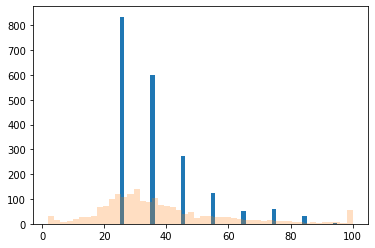

In [38]:
import matplotlib.pyplot as plt

plt.hist(y_pred, bins=50);
plt.hist(y_true, bins=50, alpha=.25);

Despite the good RMSE, the model is currently over-estimating the number of samples with Pawpularity between 20-40.

In [115]:
model = ImageClassifier(
    in_channels=3,
    num_classes=10,  # NOTE: 10 classes. All 0s is a class in itself
    pretrained=cfg.pretrained,
    cfg=cfg,
)
model.head = nn.Sequential(
    nn.LazyLinear(128),
    nn.Dropout(p=0.1),
    nn.Linear(128, 64),
)
model.head

Sequential(
  (0): LazyLinear(in_features=0, out_features=128, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=128, out_features=64, bias=True)
)

In [116]:
model.fc = nn.Linear(64, 1, bias=False)
model.linear_1_bias = nn.Parameter(torch.zeros(9).float())

In [117]:
# credit: https://stackoverflow.com/a/28127947
def new_forward(self, x):
    x = self.backbone(x)
    x = self.head(x)
    
    logits = self.fc(x) + self.linear_1_bias
    return logits
    
model.forward = new_forward.__get__(model, ImageClassifier)

In [118]:
trainer = pl.Trainer(
    gpus=1,
    precision=cfg.precision,
    auto_lr_find=cfg.auto_lr,
    accumulate_grad_batches=cfg.accumulate_grad_batches,
    auto_scale_batch_size=cfg.auto_batch_size,
    max_epochs=cfg.epochs,
)
trainer.fit(model, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type            | Params
-------------------------------------------------
0 | backbone     | SwinTransformer | 194 M 
1 | head         | Sequential      | 8.3 K 
2 | train_metric | AUROC           | 0     
3 | val_metric   | AUROC           | 0     
4 | fc           | Linear          | 64    
-------------------------------------------------
195 M     Trainable params
0         Non-trainable params
195 M     Total params
780.015   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 1 // train metric: 0.6192, valid metric: 0.7600


Validating: 0it [00:00, ?it/s]

Epoch 2 // train metric: 0.6819, valid metric: 0.7669


Validating: 0it [00:00, ?it/s]

Epoch 3 // train metric: 0.7112, valid metric: 0.7708


Validating: 0it [00:00, ?it/s]

Epoch 4 // train metric: 0.7320, valid metric: 0.7737


Validating: 0it [00:00, ?it/s]

Epoch 5 // train metric: 0.7502, valid metric: 0.7759


This is already a big improvement in AUROC! Let's see if it translates to a better RMSE.

In [119]:
import numpy as np 

outs = trainer.predict(model, dm.test_dataloader(), ckpt_path="best")
outs = np.vstack(outs)

Restoring states from the checkpoint path at /workspace/nbs/lightning_logs/version_129/checkpoints/epoch=5-step=737.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at /workspace/nbs/lightning_logs/version_129/checkpoints/epoch=5-step=737.ckpt


Predicting: 123it [00:00, ?it/s]

In [120]:
y_pred = ((outs > 0.5).sum(1) * 10) + 5
y_pred

array([ 5,  5, 95, ...,  5,  5,  5])

In [121]:
y_true = df[df.kfold==0].Pawpularity.values
y_true

array([63, 22, 53, ..., 34, 35, 20])

In [122]:
from sklearn.metrics import mean_squared_error

metric = mean_squared_error(y_pred, y_true, squared=False)
metric

35.45424578670089

In [123]:
y_pred.min(), y_pred.max()

(5, 95)

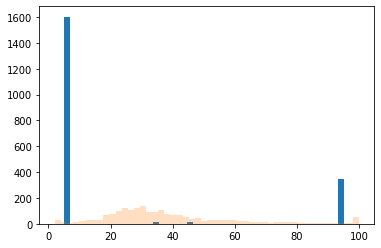

In [124]:
import matplotlib.pyplot as plt

plt.hist(y_pred, bins=50);
plt.hist(y_true, bins=50, alpha=.25);